In [ ]:
!pip3 install pandasql

# Need to know:

**Aggregate Functions**: COUNT, SUM, AVG, etc.

**Joins**

**Window Functions**: Does something and gives you an output for each row of your data. For example, if you use AVG(score), you get one row as a result. However, if you use AVG(score) OVER(), you get the average score for each row of your data. Uses the OVER() clause. Inside the OVER clause, you can use PARTITION BY and ORDER BY. 

Examples include:
- FIRST_VALUE()
- LAG()
- LAST_VALUE()
- LEAD()
- AVG()
- COUNT()
- MAX()
- MIN()
- SUM()
- CUME_DIST()
- DENSE_RANK()
- NTILE()
- PERCENT_RANK()
- RANK()
- ROW_NUMBER()

**Common Table Expressions CTE**: WITH CTE_Name AS ( select .... from ... ). Create temporary tables that you can query from.

WITH Joined_table as
SELECT *
From table1
INNER JOIN table2 on table1.date = table2.date AND table1.id = table2.id

In [3]:
import pandas as pd
import pandasql

read_sql = lambda x: pandasql.sqldf(x, globals())

**QUERY 1**

For each user_id, find the time difference between the last action and the second last action. Action here is defined as visiting a page. If the user has just one action, you can either remove her from the final results or keep that user_id and have NULL as time difference between the two actions.
The table below shows for each user all the pages she visited and the corresponding timestamp.

In [2]:
query_one = pd.read_csv("SQLData/query_one.csv")

In [20]:
sql = """

"""
read_sql(sql)

sql = """
WITH cte AS(
  SELECT user_id, unix_timestamp, 
    LAG(unix_timestamp, 1) OVER(PARTITION BY user_id ORDER BY unix_timestamp) AS prev_time,
    ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY unix_timestamp DESC) AS row_order
  FROM query_one
)
SELECT user_id, unix_timestamp - prev_time AS delta
FROM cte
WHERE row_order = 1
"""
read_sql(sql)

**Query 2**

We have two tables. One table has all mobile actions, i.e. all pages visited by the users on mobile. The other table has all web actions, i.e. all pages visited on web by the users.
Write a query that returns the percentage of users who only visited mobile, only web and both. That is, the percentage of users who are only in the mobile table, only in the web table and in both tables. The sum of the percentages should return 1.

In [22]:
mobile = pd.read_csv('SQLData/query_two/query_two_mobile.csv')
web = pd.read_csv('SQLData/query_two/query_two_web.csv')

In [35]:
sql = """

"""
read_sql(sql)

Full Outer Join looks like:
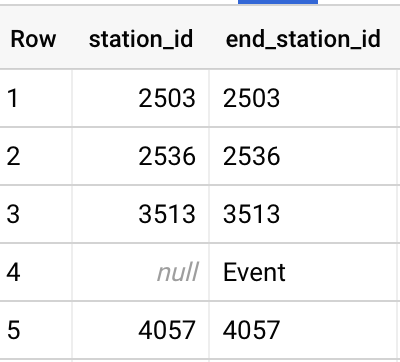

**Query 3**

We define as power users those users who bought at least 10 products. Write a query that returns for each user on which day they became a power user. That is, for each user, on which day they bought the 10th item.
The table below represents transactions. That is, each row means that the corresponding user has bought something on that date.

In [4]:
users = pd.read_csv('SQLData/query_three.csv')

In [9]:
sql = """

"""
read_sql(sql)

**Query 4**

We have two tables. One table has all $ transactions from users during the month of March and one for the month of April.
- Write a query that returns the total amount of money spent by each user. That is, the sum of the column transaction_amount for each user over both tables.
- Write a query that returns day by day the cumulative sum of money spent by each user. That is, each day a user had a transcation, we should have how much money she has spent in total until that day. Obviously, the last day cumulative sum should match the numbers from the previous bullet point. **note:** There might be more than 1 purchase made on the same day. You want to sum up those purchases so they show up only once.

In [10]:
march = pd.read_csv("SQLData/query_four/query_four_march.csv")
april = pd.read_csv("SQLData/query_four/query_four_april.csv")

In [36]:
sql = """

"""
read_sql(sql)

In [37]:
sql = """

"""
read_sql(sql)

**Query 5**

We have two tables. One is user id and their signup date. The other one shows all transactions done by those users, when the transaction happens and its corresponding dollar amount.
Find the average and median transaction amount only considering those transactions that happen on the same date as that user signed-up.

In [39]:
transactions = pd.read_csv("SQLData/query_five/query_five_transactions.csv")
users = pd.read_csv("SQLData/query_five/query_five_users.csv")

In [56]:
# LEFT join users to transactions. Keep rows where transaction_date = signup date. Order transaction amount asc
sql = """

"""
read_sql(sql)

,MEAN,median
0,49.246257,49.0


**Query 6**


We have a table with users, their country and when they created the account. We want to find:
- The country with the largest and smallest number of users
- A query that returns for each country the first and the last user who signed up (if that country has just one user, it should just return that single user)

In [59]:
data = pd.read_csv("SQLData/query_six.csv")

In [92]:
sql = """

"""
read_sql(sql)

In [96]:
sql = """

"""
read_sql(sql)

Q1: A delivery is flagged as “extremely late” if its actual delivery time is 20 minutes after its predicted delivery time. What is the % of orders that were “extremely late,” grouped by month?

In [ ]:
SELECT
    TRUNC(order_place_time, 'mm') AS delivery_month,
    SUM(CASE WHEN (actual_delivery_time - predicted_delivery_time) > 20 THEN 1 ELSE 0 END) / COUNT(*) AS pct_extremely_late
FROM
    delivery_orders
GROUP BY 1
ORDER BY delivery_month


Q2: Looking at Dashers completing their first ever order: what % of Dashers’ first-ever orders have a rating of 0?

In [ ]:
WITH first_delivery AS
    (
    SELECT
        dasher_id,
        ROW_NUMBER() OVER(PARTITION BY dasher_id ORDER BY actual_delivery_time) AS order_num,
        delivery_rating
    FROM
        delivery_orders
    ),
total_dasher AS
    (
    SELECT
        COUNT(DISTINCT dasher_id) AS total_dasher
    FROM
        delivery_orders
    )
SELECT
    COUNT(*) / b.total_dasher
FROM
    first_delivery a
LEFT JOIN
    total_dasher b
    ON 1 = 1
WHERE
    order_num = 1
    AND delivery_rating = 0

 Use the `order_value` table and the `delivery_orders` table to answer the next question. In the year 2020, grouped by month: what % of our DoorDash’s restaurant base fulfilled more than $100 in monthly sales.
Example: If Bob’s Burgers fulfilled $120 in sales in June 2020 but $90 of sales in August 2020, we would say they are counted as a “yes” for June and a “No” for August.

In [ ]:
WITH restaurant_sales AS
    (
    SELECT
        TRUNC(d.order_place_time, 'mm') AS order_month
        d.restaurant_id,
        SUM(o.sales) AS total_sales
    FROM
        delivery_orders d
    LEFT JOIN
        order_value o
        ON o.delivery_id = d.delivery_id
    GROUP BY 1, 2
    HAVING total_sales > 100
    ),
restaurant_count AS
    (
    SELECT
        TRUNC(d.order_place_time, 'mm') order_month,
        COUNT(DISTINCT d.restaurant_id) AS restaurant_count
    FROM
        delivery_orders d
    GROUP BY 1
    )
SELECT
    r.order_month,
    COUNT(d.restaurant_id) / restaurant_count
FROM
    restaurant_sales r
LEFT JOIN
    restaurant_count c
    ON c.order_month = d.order_month
GROUP BY 1

Q4 : We want to better understand daily order value for Bob’s Burgers (restaurant_id 8) in the period between June 1, 2019 and June 30, 2019 (inclusive):
Can you show the number of aggregate order value Bob’s Burgers received every day during that time period?
Can you create a column that displays a rolling sum of Bob’s Burgers aggregate daily order value to date? Example: if we did $50 in order value on June 1st and $50 in order value on June 2nd, our rolling order value to date on June 2nd would be $100.


In [ ]:
WITH daily_totals AS
    (
    SELECT
        TRUNC(order_place_time, 'dd' ) AS day_date,
        SUM(o.sales) AS daily_totals
        FROM
            delivery_orders d
        LEFT JOIN
            order_value o
            ON o.delivery_id = d.delivery_id
    WHERE
        order_place_time >= '2019-06-01'
        AND order_place_time <= '2019-06-30'
        AND restaurant_id = 8
    GROUP BY 1
    )
SELECT
    day_date,
    SUM(daily_totals) OVER(ORDER BY day_date) AS cumulative_total,
FROM
    daily_totals (edited) 

 "we're doing a pilot program with 10 merchants, in which DoorDash is responsible for dealing with support (e.g. if the order was late or wrong, basically DoorDash is responsible for addressing it)




Q1: What metric would you monitor in this scenario?


Q2: How would you perform the AB testing? note that only 4% of all orders typically has an issue raised (edited) 


Q3: builds on Q2 and around how you would cleverly measure the causal effect


Q4: If we want to cut down the cost of support, how would you go about it?

the way I answered Q1 was discuss retention metrics. My logic is that if the customer have their issue resolved quickly, they would be a happy customer. To measure this I want to look at their satisfaction rating, retention rate (e.g. orders again within a week/month).
Q2: given that we can't do experiment by splitting order by order. I proposed doing a difference in difference by customer and restaurant (edited) 
then Q3 asks about how would you determine a group of similar restaurants/customers for the diff in diff
Q4: use ML to streamline customer support (e.g. use ML model to do auto refund if the customer gets the wrong model)

In [ ]:
Restaurant Metrics
Activation
Total signups
Total signups with at least 1 order 
Retention
Number of repeat customer per restaurant per day/week/month
Orders Per Day/Week/Month
Orders per restaurant per day
Service Hours per Restaurant Per Day
Customer-restaurant ratio
Monetization
Gross Marketplace Volume / Day / Week
 
Dasher Metrics
Activation
Total app downloads
Total signups with at least 1 delivery
Retention
Daily Active Dasher
Weekly Active Dasher
Monthly Active Dasher
Trips per driver per day 
Service hours per driver per day
% Failed Delivery (e.g. delivered wrong order, cancellation)
Dollar Earned/Session/Hr
Wait time between trips per session
Tips per driver per day
Miles traveled per driver per day
Monetization
Avg. Earnings per Trip
Active Drivers
Total Trips
 
Customer Metrics
Activation:
Total app downloads
% of signups with payment information
Total signups with at least 1 order
Cost Per Acquisition
In general, for a mature marketing paid search channel without dramatic structure changes, it is relatively easy to get a cheaper CPA when the budget is low, as the ads acquire customers with high intent quickly. However, it becomes more and more expensive to acquire customers who have lower intent, meaning they need convincing rather than just being pointed in the right direction. 
As ad spending increases, it hits diminishing returns at some point with a very high CPA. Therefore, we need to ensure that whatever CPA target we set still performs well at the spend level we need
Retention:
Weekly Active User
Monthly Active User
Orders per week/month
Order-delivery time per order
% Failed Order (e.g. missing, lost, wrong orders) / week / month
% Satisfied with order
Click Through Rate for Searches